# About

Note about the dataset.

* This dataset contains the information about crypotocurrency.
* There are four cryptocurrencies given to us.
* Bitcoin cash, Bitcoin, Ethcoin and Litecoin.
* We have data available for each cryptocurrec for a few minutes.
* We need to forecast the next value of the cryptocurrency after certain time.



Note about the columns in the dataset:-
* The columns contain time given by the unix system.
* High refers to highest value of currency for the time interval.
* Low refers to lowest value of the currency for the time interval.
* Open refers to the opening value at the start of the time interval.
* Close refers the the closing value at the end of time interval.
* Volume refers to the amount of bitcoin traded.

In [143]:
pip install tensorboardcolab

# Imports

In [0]:
import pandas as pd
from sklearn import preprocessing
from collections import deque
import random
import time
import numpy as np
import os

In [0]:
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')

In [0]:
import tensorflow as tf
from keras import layers
from keras import optimizers
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint

In [147]:
from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback
tbc=TensorBoardColab()

Wait for 8 seconds...
TensorBoard link:
https://97058be3.ngrok.io


# Pre-processing

In [148]:
df = pd.read_csv('BCH-USD.csv', names = ['time', 'low', 'high', 'open', 'close', 'volume'], verbose = True)

Tokenization took: 40.92 ms
Type conversion took: 32.86 ms
Parser memory cleanup took: 0.00 ms


In [149]:
df.tail()

,time,low,high,open,close,volume
92220,1535215020,531.479980,531.479980,531.479980,531.479980,0.016868
92221,1535215080,531.469971,531.469971,531.469971,531.469971,0.013854
92222,1535215140,531.479980,531.479980,531.479980,531.479980,0.016900
92223,1535215200,531.479980,531.479980,531.479980,531.479980,0.299520
92224,1535215260,531.479980,531.630005,531.479980,531.630005,3.528913


* Need to join all the datasets using common column time.

In [150]:
main_df = pd.DataFrame()
ratios = ["BTC-USD", "LTC-USD", "BCH-USD", "ETH-USD"]
for ratio in ratios:
    # print(ratio)
    dataset = ratio + '.csv'
    df = pd.read_csv(dataset, names = ['time', 'low', 'high', 'open', 'close', 'volume'])
    df.rename(columns = {"close": ratio + "_close", "volume" : ratio + "_volume"}, inplace = True)
    df.set_index("time", inplace = True)

    df = df[[ratio + "_close", ratio + "_volume"]]
    print(df.head())
    if(len(main_df) == 0):
        main_df = df
    else:
        main_df = main_df.join(df)

            BTC-USD_close  BTC-USD_volume
time                                     
1528968660    6489.549805        0.587100
1528968720    6487.379883        7.706374
1528968780    6479.410156        3.088252
1528968840    6479.410156        1.404100
1528968900    6479.979980        0.753000
            LTC-USD_close  LTC-USD_volume
time                                     
1528968660      96.580002        9.647200
1528968720      96.660004      314.387024
1528968780      96.570000       77.129799
1528968840      96.500000        7.216067
1528968900      96.389999      524.539978
            BCH-USD_close  BCH-USD_volume
time                                     
1528968660     871.719971        5.675361
1528968720     870.859985       26.856577
1528968780     870.099976        1.124300
1528968840     870.789978        1.749862
1528968900     870.000000        1.680500
            ETH-USD_close  ETH-USD_volume
time                                     
1528968720      486.01001       26

In [151]:
for column in main_df.columns:
    print(column)

BTC-USD_close
BTC-USD_volume
LTC-USD_close
LTC-USD_volume
BCH-USD_close
BCH-USD_volume
ETH-USD_close
ETH-USD_volume


In [152]:
main_df.fillna(method = "ffill", inplace = True)     # ffill fills it using the previously known values
main_df.dropna(inplace = True)                       # If we cannot fill the dataframe still then we need to discared the values
print(main_df.head())

            BTC-USD_close  BTC-USD_volume  ...  ETH-USD_close  ETH-USD_volume
time                                       ...                               
1528968720    6487.379883        7.706374  ...      486.01001       26.019083
1528968780    6479.410156        3.088252  ...      486.00000        8.449400
1528968840    6479.410156        1.404100  ...      485.75000       26.994646
1528968900    6479.979980        0.753000  ...      486.00000       77.355759
1528968960    6480.000000        1.490900  ...      486.00000        7.503300

[5 rows x 8 columns]


In [153]:
main_df.isnull().values.any()   # This checks if there are any missing values in the main dataframe

False

# Feature Engineering


* We need to create a target output.
* Here the target output is the price the cryptocurrency.
* We need these hyper-parameters here: 
* SEQ_LEN = Length of the sequence required of the RNN.
* FUTURE_PERIOD_PREDICT = how fare we are tring to predict
* RATIO-TO-PRED = Which cryptocurrency we are predicting. 

* We can create a new column based on profit or loss.
* If the selling value of the item is greater in future than at present then we have profit.
* We can assign this to be 1.

In [0]:
SEQ_LEN = 60
FUTURE_PERIOD_PREDICT = 3  # 3 min in future
RATIO_TO_PRED = "LTC-USD"

In [0]:
def classify(current, future):
    if(future > current):
        return(1)
    else:
        return(0)
        

In [0]:
# Creating a new future column. This is created by shifting the close column by 3 minutes upwards.
main_df['future'] = main_df[RATIO_TO_PRED + "_close"].shift(-FUTURE_PERIOD_PREDICT) 

In [0]:
main_df['target'] = list(map(classify, main_df[RATIO_TO_PRED + "_close"], main_df['future']))

# Normalizing and Creating Validation Data

In [158]:
main_df.tail()

,BTC-USD_close,BTC-USD_volume,LTC-USD_close,LTC-USD_volume,BCH-USD_close,BCH-USD_volume,ETH-USD_close,ETH-USD_volume,future,target
time,,,,,,,,,,
1535214960,6713.140137,0.769891,58.020000,6.434783,531.479980,1.208560,279.359985,11.280577,58.020000,0
1535215020,6714.520020,1.002652,58.009998,7.301921,531.479980,0.016868,279.359985,8.790519,58.080002,1
1535215080,6714.520020,1.021925,58.020000,23.802017,531.469971,0.013854,279.369995,1.311763,NaN,0
1535215140,6715.000000,3.645508,58.020000,6.953497,531.479980,0.016900,279.660004,11.752819,NaN,0
1535215200,6715.000000,0.513560,58.080002,202.403183,531.479980,0.299520,279.649994,8.351710,NaN,0


* We need to pick the last 5 percent of the time data sample as validation data.

In [0]:
times = sorted(main_df.index.values)
last5_pct = sorted(main_df.index.values) [-int(0.05 * len(times))]

In [0]:
main_validation_df = main_df[(main_df.index >= last5_pct)]
main_df = main_df[(main_df.index < last5_pct)]

In [161]:
print(main_validation_df.head())

            BTC-USD_close  BTC-USD_volume  ...     future  target
time                                       ...                   
1534922100    6684.500000        0.969366  ...  57.509998       0
1534922160    6684.500000        0.611018  ...  57.509998       0
1534922220    6682.740234        1.121768  ...  57.509998       0
1534922280    6682.660156        0.912729  ...  57.500000       0
1534922340    6682.450195        0.334119  ...  57.509998       0

[5 rows x 10 columns]


In [162]:
print(main_df.head())

            BTC-USD_close  BTC-USD_volume  ...     future  target
time                                       ...                   
1528968720    6487.379883        7.706374  ...  96.389999       0
1528968780    6479.410156        3.088252  ...  96.519997       0
1528968840    6479.410156        1.404100  ...  96.440002       0
1528968900    6479.979980        0.753000  ...  96.470001       1
1528968960    6480.000000        1.490900  ...  96.400002       0

[5 rows x 10 columns]


In [0]:
def preprocess_df(df):
    # We do not need the future column, it was used only to create targets
    SEQ_LEN = 60
    df = df.drop('future', 1)
    for col in df.columns:
        if col != "target":   # We do not need to normalize the targets
            df[col] = df[col].pct_change() 
            df.dropna(inplace = True)
            df[col] = preprocessing.scale(df[col].values)
    df.dropna(inplace = True)
    # print(df.head())

    sequential_data = []
    prev_days = deque(maxlen = SEQ_LEN)
    for i in df.values:
        prev_days.append([n for n in i[:-1]])
        if(len(prev_days) == SEQ_LEN):
            sequential_data.append([np.array(prev_days), i[-1]])

    random.shuffle(sequential_data)
    # print(sequential_data.shape)
    # print(sequential_data)

    # We need to balance the dataset
    buys = []
    sells = []

    for seq, target in sequential_data:
        if(target == 0):
            sells.append([seq, target])
        elif(target == 1):
            buys.append([seq, target])
    
    random.shuffle(buys)
    random.shuffle(sells)

    # Find the lower value of buys and sells
    lower = min(len(buys), len(sells))

    # We need to restrict the number of buys
    buys = buys[:lower]
    sells = sells[:lower]

    sequential_data = buys + sells
    random.shuffle(sequential_data)

    X = []
    Y = []

    for seq, target in sequential_data:
        X.append(seq)
        Y.append(target)

    return(np.array(X), np.array(Y))

# Creating Train and Validation Sets

In [0]:
X_train, Y_train = preprocess_df(main_df)
X_val, Y_val = preprocess_df(main_validation_df)

In [165]:
print(X_train.shape, Y_train.shape)

(77922, 60, 8) (77922,)


In [166]:
print(X_val.shape, Y_val.shape)

(3860, 60, 8) (3860,)


# Building Recurrent Nueral Network

In [0]:
epochs = 50
batch_size = 256
RATIO_TO_PRED = "LTC-USD"
Name = RATIO_TO_PRED + " " + str(int(time.time())) 

In [0]:
model = Sequential()
model.add(layers.CuDNNLSTM(128, input_shape=(X_train.shape[1:]), return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(layers.BatchNormalization())  #normalizes activation outputs, same reason you want to normalize your input data.

model.add(layers.CuDNNLSTM(64,return_sequences=True))
model.add(layers.Dropout(0.1))
model.add(layers.BatchNormalization())

model.add(layers.CuDNNLSTM(32,return_sequences=False))
model.add(layers.Dropout(0.2))
model.add(layers.BatchNormalization())

model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(2, activation='softmax'))

In [0]:
optim = optimizers.SGD(lr = 0.02, momentum = 0.9)
model.compile(optimizer = optim, loss = "sparse_categorical_crossentropy", metrics = ['accuracy'])
checkpoint = ModelCheckpoint(filepath = "best_model.hdf5", monitor = 'val_acc', save_best_only=True, save_weights_only=True)

In [171]:
history = model.fit(X_train, Y_train, epochs = epochs, batch_size = batch_size, callbacks = [TensorBoardColabCallback(tbc), checkpoint], 
                   validation_data = (X_val, Y_val))

Train on 77922 samples, validate on 3860 samples
Epoch 1/50
77922/77922 [==============================] - 6s 80us/step - loss: 0.6322 - acc: 0.6384 - val_loss: 0.7088 - val_acc: 0.5591
Epoch 2/50
77922/77922 [==============================] - 6s 80us/step - loss: 0.6287 - acc: 0.6434 - val_loss: 0.7078 - val_acc: 0.5583
Epoch 3/50
77922/77922 [==============================] - 6s 79us/step - loss: 0.6281 - acc: 0.6440 - val_loss: 0.7410 - val_acc: 0.5461
Epoch 4/50
77922/77922 [==============================] - 6s 80us/step - loss: 0.6267 - acc: 0.6446 - val_loss: 0.7379 - val_acc: 0.5381
Epoch 5/50
77922/77922 [==============================] - 6s 80us/step - loss: 0.6244 - acc: 0.6453 - val_loss: 0.7217 - val_acc: 0.5490
Epoch 6/50
77922/77922 [==============================] - 6s 79us/step - loss: 0.6230 - acc: 0.6483 - val_loss: 0.7208 - val_acc: 0.5484
Epoch 7/50
77922/77922 [==============================] - 6s 79us/step - loss: 0.6208 - acc: 0.6506 - val_loss: 0.7365 - val_acc:

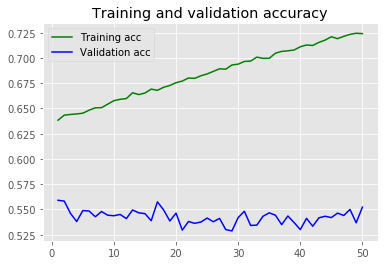

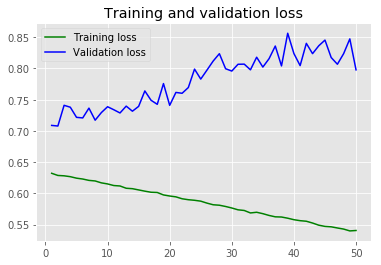

In [177]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [176]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_10 (CuDNNLSTM)    (None, 60, 128)           70656     
_________________________________________________________________
dropout_33 (Dropout)         (None, 60, 128)           0         
_________________________________________________________________
batch_normalization_25 (Batc (None, 60, 128)           512       
_________________________________________________________________
cu_dnnlstm_11 (CuDNNLSTM)    (None, 60, 64)            49664     
_________________________________________________________________
dropout_34 (Dropout)         (None, 60, 64)            0         
_________________________________________________________________
batch_normalization_26 (Batc (None, 60, 64)            256       
_________________________________________________________________
cu_dnnlstm_12 (CuDNNLSTM)    (None, 32)                12544     
__________